# Optimización de hiperparámetros

## Preparación del entorno

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

# Inserta la ruta de tu archivo zip aquí
zip_path = "/content/drive/MyDrive/TFM_OptimizacionHiperparametros/adult/adult.zip"
zip_path2 = "/content/drive/MyDrive/TFM_OptimizacionHiperparametros/bank_marketing/bank_marketing.zip"
zip_path3 = "/content/drive/MyDrive/TFM_OptimizacionHiperparametros/covertype/covertype.zip"
zip_path4 = "/content/drive/MyDrive/TFM_OptimizacionHiperparametros/poker_hand/poker_hand.zip"

# Crea un objeto ZipFile
zip_ref = zipfile.ZipFile(zip_path, "r")
zip_ref2 = zipfile.ZipFile(zip_path2, "r")
zip_ref3 = zipfile.ZipFile(zip_path3, "r")
zip_ref4 = zipfile.ZipFile(zip_path4, "r")

# Extrae todo el contenido del zip a un directorio específico
# En este caso, lo extraeremos al directorio actual ("/content")
zip_ref.extractall("/content/drive/MyDrive/TFM_OptimizacionHiperparametros/adult")
zip_ref2.extractall("/content/drive/MyDrive/TFM_OptimizacionHiperparametros/bank_marketing")
zip_ref3.extractall("/content/drive/MyDrive/TFM_OptimizacionHiperparametros/covertype")
zip_ref4.extractall("/content/drive/MyDrive/TFM_OptimizacionHiperparametros/poker_hand")

# Cierra el objeto ZipFile
zip_ref.close()
zip_ref2.close()
zip_ref3.close()
zip_ref4.close()

## Análisis de datos exploratorio

In [ ]:
!pip install optuna
!pip install keras-tuner
!pip install tensorflow
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 3.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import to_categorical
from sklearn.metrics import f1_score, recall_score, make_scorer, accuracy_score
from hyperopt import hp, fmin, STATUS_OK, Trials
from hyperopt import rand, tpe, atpe
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from kerastuner.tuners import RandomSearch, GridSearch, BayesianOptimization
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

<ipython-input-3-b04801f4aa62>:26: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, GridSearch, BayesianOptimization


### Forest Covertype Dataset

   Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238   

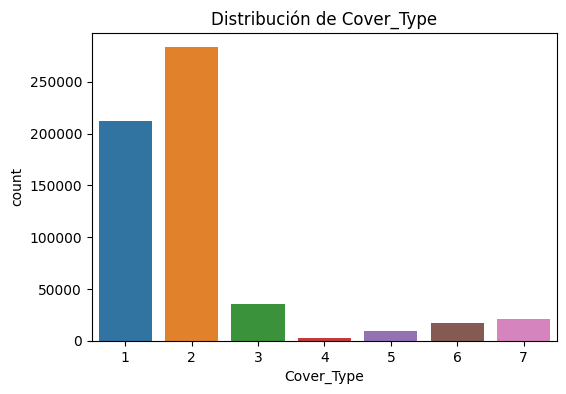

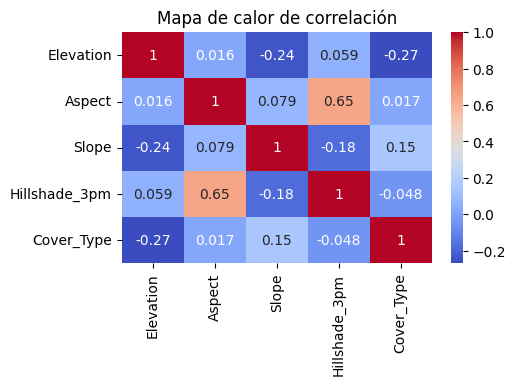

In [ ]:
# Cargar el conjunto de datos
df_cover = pd.read_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/covertype/covtype.data.gz', compression='gzip', header=None, sep=',')

# El conjunto de datos no incluye encabezados, así que los añadiremos basados en la descripción del conjunto de datos.
column_names = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
] + ['Wilderness_Area'+str(i) for i in range(1, 5)] + ['Soil_Type'+str(i) for i in range(1, 41)] + ['Cover_Type']

df_cover.columns = column_names

# Imprimir las primeras filas del conjunto de datos para verificar que se ha cargado correctamente
print(df_cover.head())

# Describir estadísticas generales del conjunto de datos
print(df_cover.describe())

# Verificar la cantidad de datos faltantes
print(df_cover.isnull().sum())

# Mostrar la distribución de la variable objetivo (Cover_Type)
plt.figure(figsize=(6, 4))
sns.countplot(x='Cover_Type', data=df_cover)
plt.title('Distribución de Cover_Type')
plt.show()

# Debido a la alta cantidad de columnas, puede ser más útil seleccionar algunas para el mapa de calor.
selected_columns = ['Elevation', 'Aspect', 'Slope', 'Hillshade_3pm', 'Cover_Type']

# Correlación entre las variables seleccionadas
plt.figure(figsize=(5, 3))
sns.heatmap(df_cover[selected_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación')
plt.show()

### Adult Dataset

   age  workclass  fnlwgt     education  educational-num      marital-status  \
0   25    Private  226802          11th                7       Never-married   
1   38    Private   89814       HS-grad                9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm               12  Married-civ-spouse   
3   44    Private  160323  Some-college               10  Married-civ-spouse   
4   18        NaN  103497  Some-college               10       Never-married   

          occupation relationship   race  gender  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                NaN    Own-child  White  Female             0             0   

   hours-per-week native-country incom

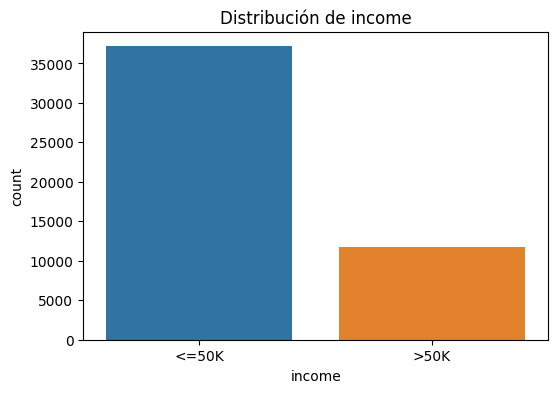

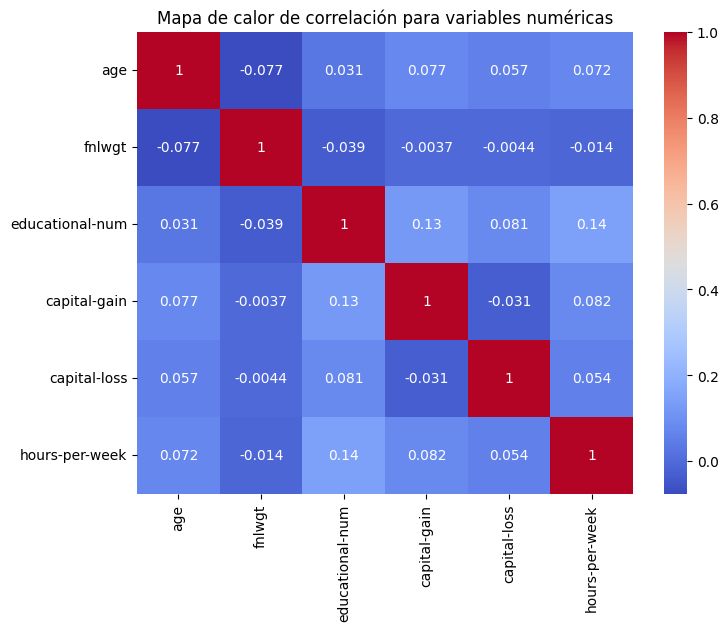

In [ ]:
# Cargar el conjunto de datos
# Asumiré que el archivo se llama 'adult.csv'
df_adult = pd.read_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/adult/adult.csv', na_values=["?"])

# Imprimir las primeras filas del conjunto de datos para verificar que se ha cargado correctamente
print(df_adult.head())

# Describir estadísticas generales del conjunto de datos
print(df_adult.describe(include='all'))

# Verificar la cantidad de datos faltantes
print(df_adult.isnull().sum())

# Mostrar la distribución de la variable objetivo (income)
plt.figure(figsize=(6, 4))
sns.countplot(x='income', data=df_adult)
plt.title('Distribución de income')
plt.show()

# Para entender las correlaciones entre las variables numéricas podemos usar un mapa de calor de correlación
numerical_features = df_adult.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(8, 6))
sns.heatmap(df_adult[numerical_features].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación para variables numéricas')
plt.show()


### Bank Marketing Dataset

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

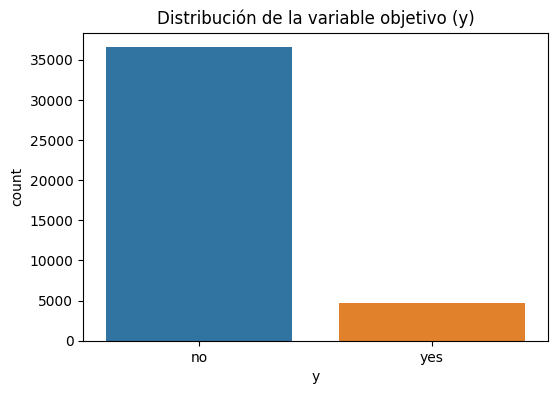

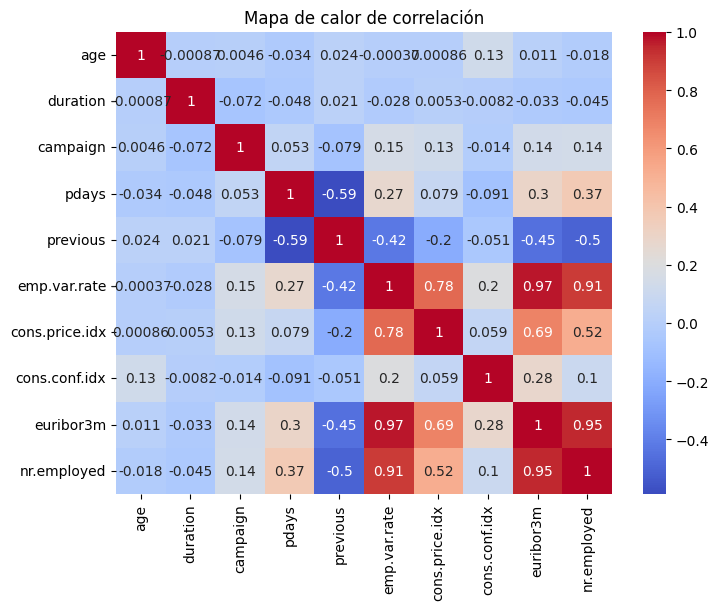

In [ ]:
# Cargar el conjunto de datos
df_bank = pd.read_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/bank_marketing/bank_additional/bank_additional_full.csv', sep=';')

# Imprimir las primeras filas del conjunto de datos para verificar que se ha cargado correctamente
print(df_bank.head())

# Describir estadísticas generales del conjunto de datos
print(df_bank.describe())

# Verificar la cantidad de datos "desconocidos", ya que los datos faltantes son etiquetados como tal
for col in df_bank.columns:
    if df_bank[col].dtype == object:
        print(col, df_bank[df_bank[col] == 'unknown'][col].count())

# Mostrar la distribución de la variable objetivo (y)
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=df_bank)
plt.title('Distribución de la variable objetivo (y)')
plt.show()

# Debido a la alta cantidad de columnas, puede ser más útil seleccionar algunas para el mapa de calor.
# Para simplificar, seleccionaremos las columnas numéricas.
numerical_columns = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

# Correlación entre las variables seleccionadas
plt.figure(figsize=(8, 6))
sns.heatmap(df_bank[numerical_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación')
plt.show()


### Poker Hand Dataset

0    513701
1    433097
2     48828
3     21634
4      3978
5      2050
6      1460
7       236
8        17
9         7
Name: CLASS, dtype: int64
   S1  C1  S2  C2  S3  C3  S4  C4  S5  C5  CLASS
0   2  11   2  13   2  10   2  12   2   1      9
1   3  12   3  11   3  13   3  10   3   1      9
2   4  10   4  11   4   1   4  13   4  12      9
3   4   1   4  13   4  12   4  11   4  10      9
4   1   2   1   4   1   5   1   3   1   6      8
                 S1            C1            S2            C2            S3  \
count  1.025008e+06  1.025008e+06  1.025008e+06  1.025008e+06  1.025008e+06   
mean   2.500698e+00  6.997864e+00  2.499844e+00  7.006285e+00  2.501101e+00   
std    1.117736e+00  3.743527e+00  1.118645e+00  3.744051e+00  1.118345e+00   
min    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.000000e+00  4.000000e+00  1.000000e+00  4.000000e+00  1.000000e+00   
50%    3.000000e+00  7.000000e+00  2.000000e+00  7.000000e+00  3.000000e+00   
75%    

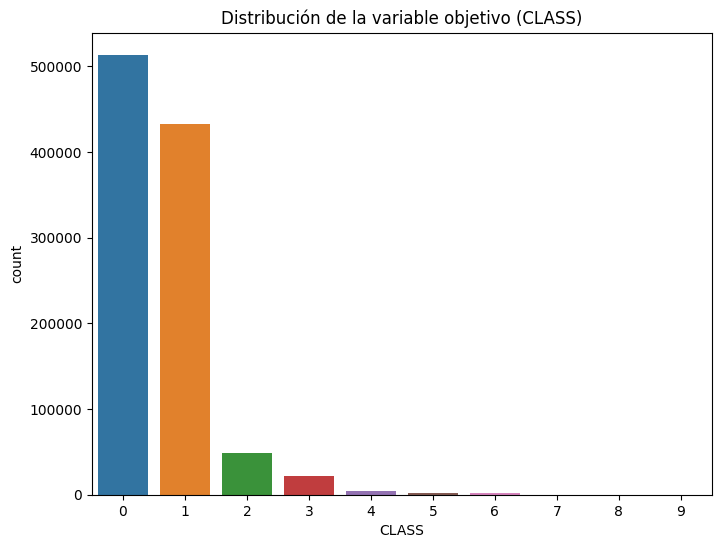

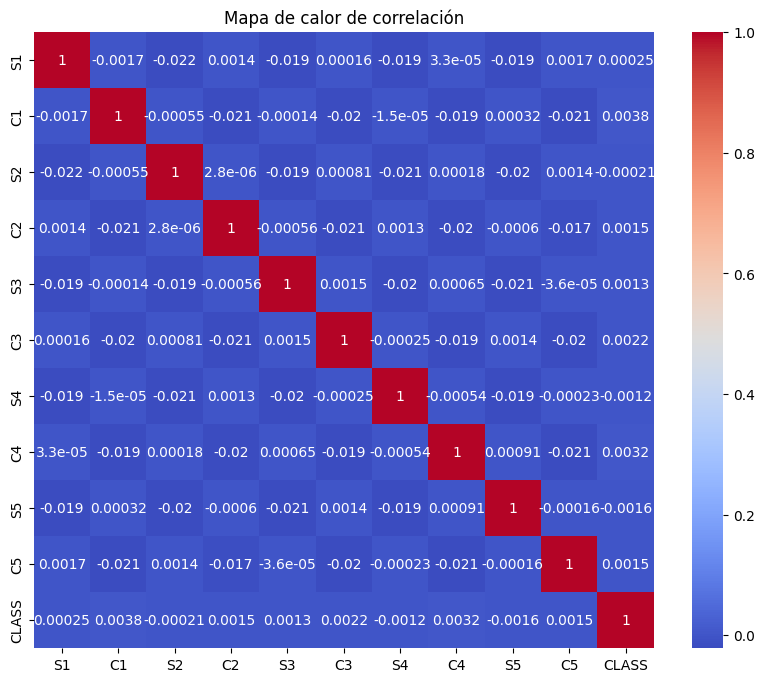

In [ ]:
# Cargar el conjunto de datos de entrenamiento
df_train = pd.read_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/poker_hand/poker-hand-training-true.data')

# Cargar el conjunto de datos de prueba
df_test = pd.read_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/poker_hand/poker-hand-testing.data')

# Asumiendo que las columnas no vienen en los archivos, las agregamos manualmente
df_train.columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS']
df_test.columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'CLASS']

# Concatenar los dos dataframes
df_poker = pd.concat([df_train, df_test])

# Guardar el dataframe combinado como un nuevo archivo CSV
df_poker.to_csv('/content/drive/MyDrive/TFM_OptimizacionHiperparametros/poker_hand/poker-hand-full.csv', index=False)

print(df_poker['CLASS'].value_counts())

# Imprimir las primeras filas del conjunto de datos para verificar que se ha cargado correctamente
print(df_poker.head())

# Describir estadísticas generales del conjunto de datos
print(df_poker.describe())

# Verificar la cantidad de datos faltantes
print(df_poker.isnull().sum())

# Mostrar la distribución de la variable objetivo (CLASS)
plt.figure(figsize=(8, 6))
sns.countplot(x='CLASS', data=df_poker)
plt.title('Distribución de la variable objetivo (CLASS)')
plt.show()

# Correlación entre las variables
plt.figure(figsize=(10, 8))
sns.heatmap(df_poker.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de calor de correlación')
plt.show()

## Preprocesado de los datos

### Preprocesado Forest Covertype

In [ ]:
X_cover = df_cover.drop('Cover_Type', axis=1)
y_cover = df_cover['Cover_Type']

# Convertir las etiquetas a formato categórico
y_cover = to_categorical(y_cover - 1)  # Restamos 1 porque las clases deben comenzar desde 0 para to_categorical

# Dividir los datos antes del preprocesamiento
X_train, X_test, y_train_cover, y_test_cover = train_test_split(X_cover, y_cover, test_size=0.2, random_state=42)

# Escalado
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Nota: usamos transform(), no fit_transform()

# PCA
pca = PCA()
X_train_cover = pca.fit_transform(X_train_scaled)
X_test_cover = pca.transform(X_test_scaled)  # Nota: usamos transform(), no fit_transform()

# Verificamos la cantidad de componentes
print("Número de componentes PCA: ", pca.n_components_)

# Varianza explicada
explained_variance = pca.explained_variance_ratio_
print("Varianza explicada por cada componente:", explained_variance)
print("Varianza explicada acumulada:", np.cumsum(explained_variance))

Número de componentes PCA:  54
Varianza explicada por cada componente: [6.85487176e-02 5.40885911e-02 4.44205734e-02 3.70631318e-02
 2.81564794e-02 2.70959112e-02 2.27528635e-02 2.15787657e-02
 2.04275192e-02 2.00885049e-02 1.98864694e-02 1.97675287e-02
 1.95321682e-02 1.92270535e-02 1.91888432e-02 1.91168991e-02
 1.90073211e-02 1.89725542e-02 1.89249564e-02 1.88209370e-02
 1.87859396e-02 1.87665818e-02 1.87078496e-02 1.86878884e-02
 1.86628515e-02 1.86410289e-02 1.86350207e-02 1.85998587e-02
 1.85945429e-02 1.85927608e-02 1.85877539e-02 1.85746023e-02
 1.85609861e-02 1.85415470e-02 1.85376194e-02 1.85319165e-02
 1.85271990e-02 1.85223915e-02 1.85187075e-02 1.81466827e-02
 1.52845427e-02 1.49400565e-02 1.19256696e-02 1.17406917e-02
 8.51195910e-03 7.69457774e-03 6.04691943e-03 5.35279433e-03
 4.65683480e-03 2.88044420e-03 2.51617613e-03 5.98162701e-05
 1.35188507e-32 1.64815064e-33]
Varianza explicada acumulada: [0.06854872 0.12263731 0.16705788 0.20412101 0.23227749 0.2593734
 0.28212

### Preprocesado Adult

In [ ]:
X_adult = df_adult.drop('income', axis=1)
y_adult = df_adult['income']

# Separar los datos en entrenamiento y prueba
X_train_adult, X_test_adult, y_train_adult, y_test_adult = train_test_split(X_adult, y_adult, test_size=0.2, random_state=42)

le = LabelEncoder()
y_train_adult = le.fit_transform(y_train_adult)
y_test_adult = le.transform(y_test_adult)

# Seleccionar columnas categóricas
cat_cols = X_train_adult.select_dtypes(include=['object']).columns

# Imputer para valores categóricos
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_adult[cat_cols] = cat_imputer.fit_transform(X_train_adult[cat_cols])
X_test_adult[cat_cols] = cat_imputer.transform(X_test_adult[cat_cols])

# Seleccionar columnas numéricas
num_cols = X_train_adult.select_dtypes(include=['int64', 'float64']).columns

# Imputer para valores numéricos
num_imputer = SimpleImputer(strategy='median')
X_train_adult[num_cols] = num_imputer.fit_transform(X_train_adult[num_cols])
X_test_adult[num_cols] = num_imputer.transform(X_test_adult[num_cols])

# Codificación One-Hot para variables categóricas
X_train_adult = pd.get_dummies(X_train_adult, drop_first=True)
X_test_adult = pd.get_dummies(X_test_adult, drop_first=True)

# Asegurarse de que los conjuntos de entrenamiento y prueba tengan las mismas columnas
missing_cols = set(X_train_adult.columns) - set(X_test_adult.columns)
for c in missing_cols:
    X_test_adult[c] = 0
X_test_adult = X_test_adult[X_train_adult.columns]

# Escalado de características numéricas
scaler = StandardScaler()
X_train_adult[num_cols] = scaler.fit_transform(X_train_adult[num_cols])
X_test_adult[num_cols] = scaler.transform(X_test_adult[num_cols])

### Preprocesado Bank Marketing

In [ ]:
X_bank = df_bank.drop(['y', 'duration'], axis=1) # Eliminar la columna 'y' y 'duration'
y_bank = df_bank['y']

# Convertir las etiquetas 'y' de 'yes'/'no' a 1/0
y_bank = df_bank['y'].map({'yes': 1, 'no': 0})

X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(X_bank, y_bank, test_size=0.2, random_state=42)

# Seleccionar columnas categóricas
cat_cols = X_train_bank.select_dtypes(include=['object']).columns

for col in cat_cols:
    most_common = X_train_bank[col].value_counts().index[0]
    # Si el más común es 'unknown', escogemos el siguiente
    if most_common == 'unknown':
        most_common = X_train_bank[col].value_counts().index[1]
    X_train_bank[col].replace('unknown', most_common, inplace=True)

for col in cat_cols:
    most_common = X_train_bank[col].value_counts().index[0]
    X_test_bank[col].replace('unknown', most_common, inplace=True)

# Ajustar el OneHotEncoder en el conjunto de entrenamiento
encoder = OneHotEncoder(drop='first').fit(X_train_bank[cat_cols])

# Transformar ambos conjuntos con el mismo codificador
X_train_bank_encoded = encoder.transform(X_train_bank[cat_cols])
X_test_bank_encoded = encoder.transform(X_test_bank[cat_cols])

# Convertir las matrices dispersas resultantes a DataFrames
X_train_bank_encoded = pd.DataFrame(X_train_bank_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))
X_test_bank_encoded = pd.DataFrame(X_test_bank_encoded.toarray(), columns=encoder.get_feature_names_out(cat_cols))

# Reemplazar las columnas categóricas originales con las nuevas columnas codificadas
X_train_bank = X_train_bank.drop(columns=cat_cols).join(X_train_bank_encoded)
X_test_bank = X_test_bank.drop(columns=cat_cols).join(X_test_bank_encoded)

# Seleccionar columnas numéricas
num_cols = X_train_bank.select_dtypes(include=['int64', 'float64']).columns

# Imputar valores perdidos con la media
imputer = SimpleImputer(strategy='mean')

# Aplicar el imputador a las columnas numéricas
X_train_bank[num_cols] = imputer.fit_transform(X_train_bank[num_cols])
X_test_bank[num_cols] = imputer.transform(X_test_bank[num_cols])

# Escalado
scaler = StandardScaler()
X_train_bank[num_cols] = scaler.fit_transform(X_train_bank[num_cols])
X_test_bank[num_cols] = scaler.transform(X_test_bank[num_cols])

# PCA
pca = PCA()
X_train_bank = pca.fit_transform(X_train_bank)
X_test_bank = pca.transform(X_test_bank)

### Preprocesado Poker Hand

In [ ]:
# Definir las características y la variable objetivo
X_poker = df_poker.drop('CLASS', axis=1)
y_poker = df_poker['CLASS']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train_poker, X_test_poker, y_train_poker, y_test_poker = train_test_split(X_poker, y_poker, test_size=0.2, random_state=42)

# Estandarizar las características
scaler = StandardScaler()

X_train_poker = scaler.fit_transform(X_train_poker)
X_test_poker = scaler.transform(X_test_poker)

## Creación y configuración de los modelos e hiperparámetros

### Optuna

**Forest Covertype Dataset**

Neural Network

In [ ]:
def objective_neural_network(trial):
    # Espacio de búsqueda
    n_units = trial.suggest_int('n_units', 10, 50)  # número de neuronas en la capa oculta
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # optimizador
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # tasa de aprendizaje
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])  # tamaño del lote

    # Construcción del modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_cover.shape[1], activation='relu'))  # capa oculta
    model.add(Dense(7, activation='softmax'))  # capa de salida

    # Selección del optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilación del modelo
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    model.fit(X_train_cover, y_train_cover, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluación del modelo
    loss, accuracy = model.evaluate(X_test_cover, y_test_cover, verbose=0)

    # Predecir las clases de los datos de prueba
    y_pred = np.argmax(model.predict(X_test_cover), axis=-1)

    # Calcular las métricas adicionales
    f1 = f1_score(np.argmax(y_test_cover, axis=-1), y_pred, average='weighted', zero_division=1)
    recall = recall_score(np.argmax(y_test_cover, axis=-1), y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_units': list(range(10, 50, 10)),
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'lr': list(np.logspace(-5, -1, num=10)),
    'batch_size': [16, 32, 64, 128, 256]
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 02:26:53,361] A new study created in memory with name: no-name-c8d32d6a-798c-4b55-b743-7a4c97a7d6cc


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:30:33,094] Trial 0 finished with value: 0.7276576161384583 and parameters: {'n_units': 20, 'optimizer': 'RMSprop', 'lr': 2.782559402207126e-05, 'batch_size': 16}. Best is trial 0 with value: 0.7276576161384583.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 02:31:32,564] Trial 1 finished with value: 0.7855648994445801 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 0.0016681005372000592, 'batch_size': 128}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:32:03,340] Trial 2 finished with value: 0.7036565542221069 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 2.782559402207126e-05, 'batch_size': 256}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 02:33:35,351] Trial 3 finished with value: 0.6570656299591064 and parameters: {'n_units': 30, 'optimizer': 'RMSprop', 'lr': 0.1, 'batch_size': 32}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:36:23,297] Trial 4 finished with value: 0.7521578669548035 and parameters: {'n_units': 40, 'optimizer': 'Adam', 'lr': 7.742636826811278e-05, 'batch_size': 16}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:39:59,494] Trial 5 finished with value: 0.7250759601593018 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 0.03593813663804626, 'batch_size': 16}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:42:45,095] Trial 6 finished with value: 0.5521802306175232 and parameters: {'n_units': 30, 'optimizer': 'RMSprop', 'lr': 0.1, 'batch_size': 16}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 9s 2ms/step


[I 2023-07-25 02:43:49,208] Trial 7 finished with value: 0.779566764831543 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 0.012915496650148827, 'batch_size': 64}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 02:45:29,917] Trial 8 finished with value: 0.7632763385772705 and parameters: {'n_units': 20, 'optimizer': 'SGD', 'lr': 0.1, 'batch_size': 64}. Best is trial 1 with value: 0.7855648994445801.


3632/3632 [==============================] - 8s 2ms/step


[I 2023-07-25 02:46:06,554] Trial 9 finished with value: 0.5428001284599304 and parameters: {'n_units': 30, 'optimizer': 'Adam', 'lr': 1e-05, 'batch_size': 256}. Best is trial 1 with value: 0.7855648994445801.


Mejor trial hasta ahora:
  Valor:  0.7855648994445801
  f1_score:  0.781111956052385
  recall:  0.7855649165684191
  Params: 
    n_units: 40
    optimizer: RMSprop
    lr: 0.0016681005372000592
    batch_size: 128


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 02:46:06,579] A new study created in memory with name: no-name-063b11e2-44af-408a-830a-095fef476944


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 02:47:02,300] Trial 0 finished with value: 0.7252652645111084 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7252652645111084.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:48:05,415] Trial 1 finished with value: 0.7181398272514343 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7252652645111084.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 02:51:43,978] Trial 2 finished with value: 0.7779489159584045 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 02:55:23,785] Trial 3 finished with value: 0.6641395092010498 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 9s 2ms/step


[I 2023-07-25 02:58:12,931] Trial 4 finished with value: 0.746426522731781 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:00:56,887] Trial 5 finished with value: 0.7516415119171143 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 03:01:20,424] Trial 6 finished with value: 0.49810245633125305 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 03:03:01,359] Trial 7 finished with value: 0.7626825571060181 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 03:03:38,241] Trial 8 finished with value: 0.752872109413147 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 2 with value: 0.7779489159584045.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:05:04,387] Trial 9 finished with value: 0.7475194334983826 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 2 with value: 0.7779489159584045.


Mejor trial hasta ahora:
  Valor:  0.7779489159584045
  f1_score:  0.7740597454663316
  recall:  0.7779489341927489
  Params: 
    n_units: 35
    optimizer: RMSprop
    lr: 0.0006672367170464204
    batch_size: 16


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 03:05:04,418] A new study created in memory with name: no-name-39808feb-6a33-49b1-b6c5-ac2081728b8b


3632/3632 [==============================] - 7s 2ms/step


[I 2023-07-25 03:05:58,318] Trial 0 finished with value: 0.7266938090324402 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7266938090324402.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 03:06:59,249] Trial 1 finished with value: 0.7157560586929321 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 0 with value: 0.7266938090324402.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:09:39,873] Trial 2 finished with value: 0.7739472985267639 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.7739472985267639.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:12:23,956] Trial 3 finished with value: 0.6557231545448303 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.7739472985267639.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:14:55,296] Trial 4 finished with value: 0.7398862242698669 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 2 with value: 0.7739472985267639.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 03:17:43,092] Trial 5 finished with value: 0.7550923824310303 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 2 with value: 0.7739472985267639.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:18:15,273] Trial 6 finished with value: 0.4181303381919861 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 2 with value: 0.7739472985267639.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:19:55,523] Trial 7 finished with value: 0.774885356426239 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 7 with value: 0.774885356426239.


3632/3632 [==============================] - 6s 2ms/step


[I 2023-07-25 03:20:37,064] Trial 8 finished with value: 0.7503248453140259 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 7 with value: 0.774885356426239.


3632/3632 [==============================] - 5s 1ms/step


[I 2023-07-25 03:22:07,317] Trial 9 finished with value: 0.7499720454216003 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 7 with value: 0.774885356426239.


Mejor trial hasta ahora:
  Valor:  0.774885356426239
  f1_score:  0.7683035189556763
  recall:  0.7748853299828748
  Params: 
    n_units: 41
    optimizer: RMSprop
    lr: 0.00672093005015611
    batch_size: 32


KNN

In [ ]:
def objective_knn(trial):
    # Espacio de búsqueda
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)  # número de vecinos
    p = trial.suggest_int('p', 1, 2)  # métrica de distancia (1 = manhattan, 2 = euclidiana)

    # Construcción del modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenamiento del modelo
    model.fit(X_train_cover, y_train_cover)

    # Evaluación del modelo
    accuracy = model.score(X_test_cover, y_test_cover)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_cover)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_cover, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_cover, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_neighbors': list(range(1, 10, 2)),
    'p': [1, 2]  # 1 para la distancia de Manhattan, 2 para la distancia euclidiana
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10, show_progress_bar=True)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-25 22:29:44,957] A new study created in memory with name: no-name-54d67de7-c88d-486c-867b-478ca0735aa0


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2023-07-26 00:35:14,358] Trial 0 finished with value: 0.9260346118430678 and parameters: {'n_neighbors': 9, 'p': 1}. Best is trial 0 with value: 0.9260346118430678.


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 02:35:40,535] A new study created in memory with name: no-name-eb024baa-1b97-4155-91b3-bac3b7775729
[I 2023-07-26 02:44:34,988] Trial 0 finished with value: 0.8966894142147793 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8966894142147793.
[I 2023-07-26 02:53:15,982] Trial 1 finished with value: 0.8989785117423819 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 1 with value: 0.8989785117423819.


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 12:01:42,362] A new study created in memory with name: no-name-6b3a9061-b135-4957-bcd0-1230a85264a9
[I 2023-07-26 12:10:24,304] Trial 0 finished with value: 0.8966894142147793 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8966894142147793.
[I 2023-07-26 12:19:04,815] Trial 1 finished with value: 0.8989785117423819 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 1 with value: 0.8989785117423819.
[I 2023-07-26 13:53:36,186] Trial 2 finished with value: 0.8930750496975121 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 1 with value: 0.8989785117423819.
[I 2023-07-26 14:02:13,585] Trial 3 finished with value: 0.9355094102561896 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 3 with value: 0.9355094102561896.
[I 2023-07-26 14:10:55,134] Trial 4 finished with value: 0.921112191595742 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 3 with value: 0.9355094102561896.
[I 2023-07-26 14:19:32,676] Trial 5 finished wi

Random Forest

In [ ]:
def objective_random_forest(trial):
    # Espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    max_depth = trial.suggest_int('max_depth', 2, 16, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Construcción del modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   n_jobs=-1, # Utilizar todos los núcleos disponibles
                                   random_state=42)

    # Entrenamiento del modelo
    model.fit(X_train_cover, y_train_cover)

    # Evaluación del modelo
    accuracy = model.score(X_test_cover, y_test_cover)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_cover)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_cover, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_cover, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_estimators': list(range(10, 50, 10)),
    'max_depth': list(range(2, 16, 2)),
    'min_samples_split': list(range(2, 6, 1)),
    'min_samples_leaf': list(range(1, 5, 1)),
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 20:00:27,369] A new study created in memory with name: no-name-07f7a809-5121-4c14-aeec-553ef49a4668
[I 2023-07-26 20:01:25,070] Trial 0 finished with value: 0.7206956791132759 and parameters: {'n_estimators': 10, 'max_depth': 8, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.7206956791132759.
[I 2023-07-26 20:02:54,059] Trial 1 finished with value: 0.8444446356806623 and parameters: {'n_estimators': 10, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8444446356806623.
[I 2023-07-26 20:05:01,617] Trial 2 finished with value: 0.7679836148808551 and parameters: {'n_estimators': 20, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8444446356806623.
[I 2023-07-26 20:09:08,769] Trial 3 finished with value: 0.8497715205287298 and parameters: {'n_estimators': 30, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.8

Mejor trial hasta ahora:
  Valor:  0.8497715205287298
  f1_score:  0.8577434945099781
  recall:  0.8497715205287298
  Params: 
    n_estimators: 30
    max_depth: 14
    min_samples_split: 5
    min_samples_leaf: 2


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 20:23:44,758] A new study created in memory with name: no-name-8cfd9313-b1a0-470e-917d-f2989e650b3d
[I 2023-07-26 20:27:21,638] Trial 0 finished with value: 0.8633081762088759 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:27:50,147] Trial 1 finished with value: 0.46623581146786225 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:30:55,904] Trial 2 finished with value: 0.7256180993606017 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:32:15,598] Trial 3 finished with value: 0.4582239701212533 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.86

Mejor trial hasta ahora:
  Valor:  0.8633081762088759
  f1_score:  0.8709982633381015
  recall:  0.8633081762088759
  Params: 
    n_estimators: 25
    max_depth: 15
    min_samples_split: 5
    min_samples_leaf: 3


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 20:40:52,529] A new study created in memory with name: no-name-3f637d63-d96e-425a-a631-c961f410ec9b
[I 2023-07-26 20:44:22,260] Trial 0 finished with value: 0.8633081762088759 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:44:50,706] Trial 1 finished with value: 0.46623581146786225 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:47:54,055] Trial 2 finished with value: 0.7256180993606017 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8633081762088759.
[I 2023-07-26 20:49:12,312] Trial 3 finished with value: 0.4582239701212533 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.86

Mejor trial hasta ahora:
  Valor:  0.8633081762088759
  f1_score:  0.8709982633381015
  recall:  0.8633081762088759
  Params: 
    n_estimators: 25
    max_depth: 15
    min_samples_split: 5
    min_samples_leaf: 3


**Adult Dataset**

Neural Network

In [ ]:
def objective_neural_network(trial):
    # Espacio de búsqueda
    n_units = trial.suggest_int('n_units', 10, 50)  # número de neuronas en la capa oculta
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # optimizador
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # tasa de aprendizaje
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])  # tamaño del lote

    # Construcción del modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_adult.shape[1], activation='relu'))  # capa oculta
    model.add(Dense(1, activation='sigmoid'))  # capa de salida

    # Selección del optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilación del modelo
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    model.fit(X_train_adult, y_train_adult, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluación del modelo
    loss, accuracy = model.evaluate(X_test_adult, y_test_adult, verbose=0)

    # Predecir las clases de los datos de prueba
    y_pred = (model.predict(X_test_adult) > 0.5).astype("int32")

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_adult, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_adult, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_units': list(range(10, 50, 10)),
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'lr': list(np.logspace(-5, -1, num=10)),
    'batch_size': [16, 32, 64, 128, 256]
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 21:37:29,183] A new study created in memory with name: no-name-97193ba3-2aee-4907-bc30-cb027e9655b8


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:37:38,026] Trial 0 finished with value: 0.7819633483886719 and parameters: {'n_units': 30, 'optimizer': 'SGD', 'lr': 0.0005994842503189409, 'batch_size': 64}. Best is trial 0 with value: 0.7819633483886719.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:37:51,250] Trial 1 finished with value: 0.8471696376800537 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 0.03593813663804626, 'batch_size': 16}. Best is trial 1 with value: 0.8471696376800537.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:37:54,901] Trial 2 finished with value: 0.8603746294975281 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 0.03593813663804626, 'batch_size': 256}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:37:59,494] Trial 3 finished with value: 0.7936329245567322 and parameters: {'n_units': 10, 'optimizer': 'SGD', 'lr': 0.012915496650148827, 'batch_size': 256}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:38:04,294] Trial 4 finished with value: 0.7403009533882141 and parameters: {'n_units': 30, 'optimizer': 'SGD', 'lr': 0.00021544346900318823, 'batch_size': 64}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 2s 8ms/step


[I 2023-07-26 21:38:11,685] Trial 5 finished with value: 0.5081380009651184 and parameters: {'n_units': 20, 'optimizer': 'SGD', 'lr': 0.00021544346900318823, 'batch_size': 256}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:38:19,760] Trial 6 finished with value: 0.8548469543457031 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 0.00021544346900318823, 'batch_size': 32}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:38:23,034] Trial 7 finished with value: 0.7802231311798096 and parameters: {'n_units': 40, 'optimizer': 'SGD', 'lr': 0.0016681005372000592, 'batch_size': 128}. Best is trial 2 with value: 0.8603746294975281.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:38:45,702] Trial 8 finished with value: 0.8619101047515869 and parameters: {'n_units': 20, 'optimizer': 'RMSprop', 'lr': 0.0016681005372000592, 'batch_size': 16}. Best is trial 8 with value: 0.8619101047515869.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:38:50,288] Trial 9 finished with value: 0.8218855857849121 and parameters: {'n_units': 30, 'optimizer': 'Adam', 'lr': 7.742636826811278e-05, 'batch_size': 128}. Best is trial 8 with value: 0.8619101047515869.


Mejor trial hasta ahora:
  Valor:  0.8619101047515869
  f1_score:  0.8559010529006061
  recall:  0.8619101238611936
  Params: 
    n_units: 20
    optimizer: RMSprop
    lr: 0.0016681005372000592
    batch_size: 16


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 21:38:50,316] A new study created in memory with name: no-name-2028bac5-80a2-4cc5-9d6e-404c013adcfb


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:38:56,826] Trial 0 finished with value: 0.8286415934562683 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8286415934562683.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:39:01,642] Trial 1 finished with value: 0.7899478077888489 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8286415934562683.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:39:14,726] Trial 2 finished with value: 0.8611935973167419 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.8611935973167419.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:39:28,388] Trial 3 finished with value: 0.8168696761131287 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.8611935973167419.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:39:51,441] Trial 4 finished with value: 0.8514689207077026 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 2 with value: 0.8611935973167419.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:04,196] Trial 5 finished with value: 0.8494216203689575 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 2 with value: 0.8611935973167419.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:40:08,030] Trial 6 finished with value: 0.30443239212036133 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 2 with value: 0.8611935973167419.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:15,364] Trial 7 finished with value: 0.8632408380508423 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 7 with value: 0.8632408380508423.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:18,691] Trial 8 finished with value: 0.8473743200302124 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 7 with value: 0.8632408380508423.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:31,254] Trial 9 finished with value: 0.852799654006958 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 7 with value: 0.8632408380508423.


Mejor trial hasta ahora:
  Valor:  0.8632408380508423
  f1_score:  0.8580942514810204
  recall:  0.8632408639574163
  Params: 
    n_units: 41
    optimizer: RMSprop
    lr: 0.00672093005015611
    batch_size: 32


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 21:40:31,276] A new study created in memory with name: no-name-da1d2d1c-7e1f-4ec9-892f-6e744f808fbf


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:38,363] Trial 0 finished with value: 0.8196335434913635 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8196335434913635.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:42,946] Trial 1 finished with value: 0.8152318596839905 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8196335434913635.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:40:55,904] Trial 2 finished with value: 0.8630361557006836 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.8630361557006836.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:41:08,991] Trial 3 finished with value: 0.8462483286857605 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.8630361557006836.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:41:21,786] Trial 4 finished with value: 0.8529020547866821 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 2 with value: 0.8630361557006836.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:41:34,893] Trial 5 finished with value: 0.8432797789573669 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 2 with value: 0.8630361557006836.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:41:37,290] Trial 6 finished with value: 0.4017811417579651 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 2 with value: 0.8630361557006836.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:41:44,157] Trial 7 finished with value: 0.8654928803443909 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 7 with value: 0.8654928803443909.


306/306 [==============================] - 1s 2ms/step


[I 2023-07-26 21:41:49,818] Trial 8 finished with value: 0.8466578125953674 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 7 with value: 0.8654928803443909.


306/306 [==============================] - 0s 1ms/step


[I 2023-07-26 21:41:56,694] Trial 9 finished with value: 0.8535162210464478 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 7 with value: 0.8654928803443909.


Mejor trial hasta ahora:
  Valor:  0.8654928803443909
  f1_score:  0.8605125667310645
  recall:  0.8654928856587163
  Params: 
    n_units: 41
    optimizer: RMSprop
    lr: 0.00672093005015611
    batch_size: 32


KNN

In [ ]:
def objective_knn(trial):
    # Espacio de búsqueda
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)  # número de vecinos
    p = trial.suggest_int('p', 1, 2)  # métrica de distancia (1 = manhattan, 2 = euclidiana)

    # Construcción del modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenamiento del modelo
    model.fit(X_train_adult, y_train_adult)

    # Evaluación del modelo
    accuracy = model.score(X_test_adult, y_test_adult)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_adult)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_adult, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_adult, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_neighbors': list(range(1, 10, 2)),
    'p': [1, 2]  # 1 para la distancia de Manhattan, 2 para la distancia euclidiana
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 21:41:56,729] A new study created in memory with name: no-name-688c7733-15b8-4927-a1c9-7138b1ef2ac5
[I 2023-07-26 21:42:06,146] Trial 0 finished with value: 0.8409253761899887 and parameters: {'n_neighbors': 5, 'p': 2}. Best is trial 0 with value: 0.8409253761899887.
[I 2023-07-26 21:43:57,455] Trial 1 finished with value: 0.839594636093766 and parameters: {'n_neighbors': 5, 'p': 1}. Best is trial 0 with value: 0.8409253761899887.
[I 2023-07-26 21:45:46,790] Trial 2 finished with value: 0.8030504657590337 and parameters: {'n_neighbors': 1, 'p': 1}. Best is trial 0 with value: 0.8409253761899887.
[I 2023-07-26 21:45:56,050] Trial 3 finished with value: 0.8410277408127751 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 3 with value: 0.8410277408127751.
[I 2023-07-26 21:46:02,889] Trial 4 finished with value: 0.8280274337189067 and parameters: {'n_neighbors': 3, 'p': 2}. Best is trial 3 with value: 0.8410277408127751.
[I 2023-07-26 21:46:12,186] Trial 5 finished wi

Mejor trial hasta ahora:
  Valor:  0.8445081379875116
  f1_score:  0.84158855334142
  recall:  0.8445081379875116
  Params: 
    n_neighbors: 7
    p: 1


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 21:51:54,124] A new study created in memory with name: no-name-577bdd0f-e614-49a3-9aba-b10b4b5f13ab
[I 2023-07-26 21:52:01,081] Trial 0 finished with value: 0.8359095096734569 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8359095096734569.
[I 2023-07-26 21:52:10,409] Trial 1 finished with value: 0.8447128672330843 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 21:54:01,697] Trial 2 finished with value: 0.8196335346504248 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 21:54:10,906] Trial 3 finished with value: 0.8034599242501791 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 21:54:17,754] Trial 4 finished with value: 0.8410277408127751 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 21:54:26,905] Trial 5 finished w

Mejor trial hasta ahora:
  Valor:  0.8447128672330843
  f1_score:  0.8376926530739676
  recall:  0.8447128672330843
  Params: 
    n_neighbors: 8
    p: 2


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:00:08,435] A new study created in memory with name: no-name-279cba23-e877-4a22-8b0d-4b50a5f28a92
[I 2023-07-26 22:00:16,514] Trial 0 finished with value: 0.8359095096734569 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8359095096734569.
[I 2023-07-26 22:00:24,637] Trial 1 finished with value: 0.8447128672330843 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 22:02:13,494] Trial 2 finished with value: 0.8196335346504248 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 22:02:22,744] Trial 3 finished with value: 0.8034599242501791 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 22:02:29,585] Trial 4 finished with value: 0.8410277408127751 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 1 with value: 0.8447128672330843.
[I 2023-07-26 22:02:38,840] Trial 5 finished w

Mejor trial hasta ahora:
  Valor:  0.8447128672330843
  f1_score:  0.8376926530739676
  recall:  0.8447128672330843
  Params: 
    n_neighbors: 8
    p: 2


Random Forest

In [ ]:
def objective_random_forest(trial):
    # Espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    max_depth = trial.suggest_int('max_depth', 2, 16, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Construcción del modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   n_jobs=-1, # Utilizar todos los núcleos disponibles
                                   random_state=42)

    # Entrenamiento del modelo
    model.fit(X_train_adult, y_train_adult)

    # Evaluación del modelo
    accuracy = model.score(X_test_adult, y_test_adult)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_adult)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_adult, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_adult, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_estimators': list(range(10, 50, 10)),
    'max_depth': list(range(2, 16, 2)),
    'min_samples_split': list(range(2, 6, 1)),
    'min_samples_leaf': list(range(1, 5, 1)),
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:08:20,007] A new study created in memory with name: no-name-91279ddc-c5f4-4547-b70f-6b282ee744a6
[I 2023-07-26 22:08:20,249] Trial 0 finished with value: 0.8239328488074521 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8239328488074521.
[I 2023-07-26 22:08:21,490] Trial 1 finished with value: 0.8629337700890573 and parameters: {'n_estimators': 40, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8629337700890573.
[I 2023-07-26 22:08:21,810] Trial 2 finished with value: 0.8597604667826799 and parameters: {'n_estimators': 10, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8629337700890573.
[I 2023-07-26 22:08:22,224] Trial 3 finished with value: 0.8307912785341386 and parameters: {'n_estimators': 20, 'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.86

Mejor trial hasta ahora:
  Valor:  0.8649810625447846
  f1_score:  0.8573611943779232
  recall:  0.8649810625447846
  Params: 
    n_estimators: 30
    max_depth: 14
    min_samples_split: 2
    min_samples_leaf: 4


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:08:30,822] A new study created in memory with name: no-name-b850135d-da53-4db0-a0b4-cddebaa6a0c2
[I 2023-07-26 22:08:31,894] Trial 0 finished with value: 0.8640597809397073 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:32,146] Trial 1 finished with value: 0.7676323062749514 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:33,082] Trial 2 finished with value: 0.8597604667826799 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:33,595] Trial 3 finished with value: 0.7673252124065922 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.864

Mejor trial hasta ahora:
  Valor:  0.8640597809397073
  f1_score:  0.8555524535427323
  recall:  0.8640597809397073
  Params: 
    n_estimators: 25
    max_depth: 15
    min_samples_split: 5
    min_samples_leaf: 3


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:08:36,360] A new study created in memory with name: no-name-a95f196d-ad64-4707-9f29-355f84c84285
[I 2023-07-26 22:08:37,225] Trial 0 finished with value: 0.8640597809397073 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:37,461] Trial 1 finished with value: 0.7676323062749514 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:38,397] Trial 2 finished with value: 0.8597604667826799 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8640597809397073.
[I 2023-07-26 22:08:38,875] Trial 3 finished with value: 0.7673252124065922 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.864

Mejor trial hasta ahora:
  Valor:  0.8640597809397073
  f1_score:  0.8555524535427323
  recall:  0.8640597809397073
  Params: 
    n_estimators: 25
    max_depth: 15
    min_samples_split: 5
    min_samples_leaf: 3


**Bank Marketing Dataset**

Neural Network

In [ ]:
def objective_neural_network(trial):
    # Espacio de búsqueda
    n_units = trial.suggest_int('n_units', 10, 50)  # número de neuronas en la capa oculta
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])  # optimizador
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)  # tasa de aprendizaje
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128, 256])  # tamaño del lote

    # Construcción del modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_bank.shape[1], activation='relu'))  # capa oculta
    model.add(Dense(1, activation='sigmoid'))  # capa de salida

    # Selección del optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilación del modelo
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Entrenamiento del modelo
    model.fit(X_train_bank, y_train_bank, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluación del modelo
    loss, accuracy = model.evaluate(X_test_bank, y_test_bank, verbose=0)

    # Predecir las clases de los datos de prueba
    y_pred = (model.predict(X_test_bank) > 0.5).astype("int32")

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_bank, y_pred, average='binary', zero_division=1)
    recall = recall_score(y_test_bank, y_pred, average='binary', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_units': list(range(10, 50, 10)),
    'optimizer': ['Adam', 'SGD', 'RMSprop'],
    'lr': list(np.logspace(-5, -1, num=10)),
    'batch_size': [16, 32, 64, 128, 256]
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:08:43,154] A new study created in memory with name: no-name-965ed4c0-7f0a-4d62-8556-acea93ba973a


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:08:49,765] Trial 0 finished with value: 0.8952415585517883 and parameters: {'n_units': 30, 'optimizer': 'Adam', 'lr': 0.00021544346900318823, 'batch_size': 32}. Best is trial 0 with value: 0.8952415585517883.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:08:53,591] Trial 1 finished with value: 0.7320951819419861 and parameters: {'n_units': 30, 'optimizer': 'RMSprop', 'lr': 2.782559402207126e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8952415585517883.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:08:57,019] Trial 2 finished with value: 0.8965768218040466 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 0.0005994842503189409, 'batch_size': 128}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:00,392] Trial 3 finished with value: 0.8843165636062622 and parameters: {'n_units': 10, 'optimizer': 'SGD', 'lr': 7.742636826811278e-05, 'batch_size': 256}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:09:07,492] Trial 4 finished with value: 0.8865015506744385 and parameters: {'n_units': 30, 'optimizer': 'RMSprop', 'lr': 0.1, 'batch_size': 32}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 0s 2ms/step


[I 2023-07-26 22:09:10,503] Trial 5 finished with value: 0.8960912823677063 and parameters: {'n_units': 20, 'optimizer': 'RMSprop', 'lr': 0.0016681005372000592, 'batch_size': 256}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:20,554] Trial 6 finished with value: 0.8850449323654175 and parameters: {'n_units': 20, 'optimizer': 'SGD', 'lr': 0.00021544346900318823, 'batch_size': 16}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:09:27,515] Trial 7 finished with value: 0.8852877020835876 and parameters: {'n_units': 30, 'optimizer': 'Adam', 'lr': 2.782559402207126e-05, 'batch_size': 32}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:31,646] Trial 8 finished with value: 0.8831027150154114 and parameters: {'n_units': 40, 'optimizer': 'RMSprop', 'lr': 1e-05, 'batch_size': 64}. Best is trial 2 with value: 0.8965768218040466.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:35,220] Trial 9 finished with value: 0.8959698677062988 and parameters: {'n_units': 30, 'optimizer': 'SGD', 'lr': 0.03593813663804626, 'batch_size': 64}. Best is trial 2 with value: 0.8965768218040466.


Mejor trial hasta ahora:
  Valor:  0.8965768218040466
  f1_score:  0.3004926108374384
  recall:  0.19572192513368983
  Params: 
    n_units: 10
    optimizer: Adam
    lr: 0.0005994842503189409
    batch_size: 128


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:09:35,248] A new study created in memory with name: no-name-518d40d4-c74a-4624-bbd0-76a8982ebc10


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:09:40,224] Trial 0 finished with value: 0.8634377121925354 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8634377121925354.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:47,470] Trial 1 finished with value: 0.8681718707084656 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 1 with value: 0.8681718707084656.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:09:59,310] Trial 2 finished with value: 0.8943918347358704 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.8943918347358704.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:10:11,243] Trial 3 finished with value: 0.87594074010849 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.8943918347358704.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:10:23,370] Trial 4 finished with value: 0.8951202034950256 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 4 with value: 0.8951202034950256.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:10:36,113] Trial 5 finished with value: 0.8963340520858765 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 5 with value: 0.8963340520858765.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:10:40,270] Trial 6 finished with value: 0.7836853861808777 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 5 with value: 0.8963340520858765.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:10:47,191] Trial 7 finished with value: 0.8970624208450317 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 7 with value: 0.8970624208450317.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:10:52,875] Trial 8 finished with value: 0.895605742931366 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 7 with value: 0.8970624208450317.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:10:59,614] Trial 9 finished with value: 0.8964554667472839 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 7 with value: 0.8970624208450317.


Mejor trial hasta ahora:
  Valor:  0.8970624208450317
  f1_score:  0.30377668308702793
  recall:  0.19786096256684493
  Params: 
    n_units: 41
    optimizer: RMSprop
    lr: 0.00672093005015611
    batch_size: 32


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_neural_network, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:10:59,641] A new study created in memory with name: no-name-b1f77a57-469f-4493-8f02-969d6c41cd99


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:11:04,459] Trial 0 finished with value: 0.8463219404220581 and parameters: {'n_units': 25, 'optimizer': 'Adam', 'lr': 4.207988669606632e-05, 'batch_size': 64}. Best is trial 0 with value: 0.8463219404220581.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:11:09,244] Trial 1 finished with value: 0.8797038197517395 and parameters: {'n_units': 10, 'optimizer': 'Adam', 'lr': 5.3370327626039544e-05, 'batch_size': 64}. Best is trial 1 with value: 0.8797038197517395.


258/258 [==============================] - 0s 2ms/step


[I 2023-07-26 22:11:19,677] Trial 2 finished with value: 0.8966982364654541 and parameters: {'n_units': 35, 'optimizer': 'RMSprop', 'lr': 0.0006672367170464204, 'batch_size': 16}. Best is trial 2 with value: 0.8966982364654541.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:11:32,425] Trial 3 finished with value: 0.8844379782676697 and parameters: {'n_units': 34, 'optimizer': 'RMSprop', 'lr': 0.07286653737491042, 'batch_size': 16}. Best is trial 2 with value: 0.8966982364654541.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:11:44,801] Trial 4 finished with value: 0.8964554667472839 and parameters: {'n_units': 15, 'optimizer': 'RMSprop', 'lr': 0.00010842262717330161, 'batch_size': 16}. Best is trial 2 with value: 0.8966982364654541.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:11:56,832] Trial 5 finished with value: 0.8960912823677063 and parameters: {'n_units': 49, 'optimizer': 'SGD', 'lr': 0.002463768595899745, 'batch_size': 16}. Best is trial 2 with value: 0.8966982364654541.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:11:59,173] Trial 6 finished with value: 0.4732944965362549 and parameters: {'n_units': 25, 'optimizer': 'SGD', 'lr': 0.000132965214572995, 'batch_size': 256}. Best is trial 2 with value: 0.8966982364654541.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:12:06,357] Trial 7 finished with value: 0.8976693153381348 and parameters: {'n_units': 41, 'optimizer': 'RMSprop', 'lr': 0.00672093005015611, 'batch_size': 32}. Best is trial 7 with value: 0.8976693153381348.


258/258 [==============================] - 0s 1ms/step


[I 2023-07-26 22:12:09,421] Trial 8 finished with value: 0.8948773741722107 and parameters: {'n_units': 45, 'optimizer': 'Adam', 'lr': 0.00017535949529764417, 'batch_size': 128}. Best is trial 7 with value: 0.8976693153381348.


258/258 [==============================] - 1s 2ms/step


[I 2023-07-26 22:12:16,158] Trial 9 finished with value: 0.895605742931366 and parameters: {'n_units': 14, 'optimizer': 'SGD', 'lr': 0.012130221181165156, 'batch_size': 32}. Best is trial 7 with value: 0.8976693153381348.


Mejor trial hasta ahora:
  Valor:  0.8976693153381348
  f1_score:  0.29925187032418954
  recall:  0.1925133689839572
  Params: 
    n_units: 41
    optimizer: RMSprop
    lr: 0.00672093005015611
    batch_size: 32


KNN

In [ ]:
def objective_knn(trial):
    # Espacio de búsqueda
    n_neighbors = trial.suggest_int('n_neighbors', 1, 10)  # número de vecinos
    p = trial.suggest_int('p', 1, 2)  # métrica de distancia (1 = manhattan, 2 = euclidiana)

    # Construcción del modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenamiento del modelo
    model.fit(X_train_bank, y_train_bank)

    # Evaluación del modelo
    accuracy = model.score(X_test_bank, y_test_bank)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_bank)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_bank, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_bank, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_neighbors': list(range(1, 10, 2)),
    'p': [1, 2]  # 1 para la distancia de Manhattan, 2 para la distancia euclidiana
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:12:16,209] A new study created in memory with name: no-name-a591ce1e-2e31-499a-8e29-c992c1bea17d
[I 2023-07-26 22:12:23,288] Trial 0 finished with value: 0.8901432386501578 and parameters: {'n_neighbors': 5, 'p': 2}. Best is trial 0 with value: 0.8901432386501578.
[I 2023-07-26 22:13:00,024] Trial 1 finished with value: 0.7598931779558146 and parameters: {'n_neighbors': 1, 'p': 1}. Best is trial 0 with value: 0.8901432386501578.
[I 2023-07-26 22:13:03,629] Trial 2 finished with value: 0.887229910172372 and parameters: {'n_neighbors': 3, 'p': 2}. Best is trial 0 with value: 0.8901432386501578.
[I 2023-07-26 22:13:43,093] Trial 3 finished with value: 0.8300558387958242 and parameters: {'n_neighbors': 9, 'p': 1}. Best is trial 0 with value: 0.8901432386501578.
[I 2023-07-26 22:13:46,713] Trial 4 finished with value: 0.8901432386501578 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 0 with value: 0.8901432386501578.
[I 2023-07-26 22:13:50,849] Trial 5 finished wi

Mejor trial hasta ahora:
  Valor:  0.8923282350084972
  f1_score:  0.8726558206894165
  recall:  0.8923282350084972
  Params: 
    n_neighbors: 9
    p: 2


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:15:52,206] A new study created in memory with name: no-name-6e32da05-3e88-4334-a74a-bc15de097781
[I 2023-07-26 22:15:55,867] Trial 0 finished with value: 0.8932993445010925 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:16:01,731] Trial 1 finished with value: 0.8926924010682205 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:16:38,719] Trial 2 finished with value: 0.8309055596018451 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:16:42,277] Trial 3 finished with value: 0.8630735615440641 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:16:48,264] Trial 4 finished with value: 0.8901432386501578 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:16:51,833] Trial 5 finished w

Mejor trial hasta ahora:
  Valor:  0.8932993445010925
  f1_score:  0.8666995623086876
  recall:  0.8932993445010925
  Params: 
    n_neighbors: 4
    p: 2


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_knn, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:18:53,835] A new study created in memory with name: no-name-3d3dbec2-05f1-4323-a8bc-39ce1fbfa168
[I 2023-07-26 22:18:57,494] Trial 0 finished with value: 0.8932993445010925 and parameters: {'n_neighbors': 4, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:19:01,150] Trial 1 finished with value: 0.8926924010682205 and parameters: {'n_neighbors': 8, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:19:40,507] Trial 2 finished with value: 0.8309055596018451 and parameters: {'n_neighbors': 2, 'p': 1}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:19:44,097] Trial 3 finished with value: 0.8630735615440641 and parameters: {'n_neighbors': 1, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:19:47,725] Trial 4 finished with value: 0.8901432386501578 and parameters: {'n_neighbors': 7, 'p': 2}. Best is trial 0 with value: 0.8932993445010925.
[I 2023-07-26 22:19:53,495] Trial 5 finished w

Mejor trial hasta ahora:
  Valor:  0.8932993445010925
  f1_score:  0.8666995623086876
  recall:  0.8932993445010925
  Params: 
    n_neighbors: 4
    p: 2


Random Forest

In [ ]:
def objective_random_forest(trial):
    # Espacio de búsqueda
    n_estimators = trial.suggest_int('n_estimators', 10, 50)
    max_depth = trial.suggest_int('max_depth', 2, 16, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 6)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Construcción del modelo
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   n_jobs=-1, # Utilizar todos los núcleos disponibles
                                   random_state=42)

    # Entrenamiento del modelo
    model.fit(X_train_bank, y_train_bank)

    # Evaluación del modelo
    accuracy = model.score(X_test_bank, y_test_bank)

    # Predecir las clases de los datos de prueba
    y_pred = model.predict(X_test_bank)

    # Calcular las métricas adicionales
    f1 = f1_score(y_test_bank, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_bank, y_pred, average='weighted', zero_division=1)

    # Almacenar las métricas en el trial
    trial.set_user_attr('f1_score', f1)
    trial.set_user_attr('recall', recall)

    # Retorno del valor a optimizar
    return accuracy

In [ ]:
# Grid Search
# Espacio de búsqueda para GridSampler
param_grid = {
    'n_estimators': list(range(10, 50, 10)),
    'max_depth': list(range(2, 16, 2)),
    'min_samples_split': list(range(2, 6, 1)),
    'min_samples_leaf': list(range(1, 5, 1)),
}
sampler = optuna.samplers.GridSampler(param_grid)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:21:53,105] A new study created in memory with name: no-name-0349639d-84ae-4098-be37-deaddcf48f5f
[I 2023-07-26 22:22:01,414] Trial 0 finished with value: 0.8962126729788784 and parameters: {'n_estimators': 40, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8962126729788784.
[I 2023-07-26 22:22:06,440] Trial 1 finished with value: 0.8935421218742413 and parameters: {'n_estimators': 30, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8962126729788784.
[I 2023-07-26 22:22:08,418] Trial 2 finished with value: 0.8969410050983249 and parameters: {'n_estimators': 20, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8969410050983249.
[I 2023-07-26 22:22:09,773] Trial 3 finished with value: 0.8951201747997086 and parameters: {'n_estimators': 10, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.89

Mejor trial hasta ahora:
  Valor:  0.8969410050983249
  f1_score:  0.8704940702649496
  recall:  0.8969410050983249
  Params: 
    n_estimators: 20
    max_depth: 6
    min_samples_split: 4
    min_samples_leaf: 2


In [ ]:
# Random Search
sampler = optuna.samplers.RandomSampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:22:21,537] A new study created in memory with name: no-name-d3bdcd66-9661-483a-bbf2-4f6a2e642285
[I 2023-07-26 22:22:29,063] Trial 0 finished with value: 0.8923282350084972 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8923282350084972.
[I 2023-07-26 22:22:29,665] Trial 1 finished with value: 0.8883224083515416 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8923282350084972.
[I 2023-07-26 22:22:33,572] Trial 2 finished with value: 0.8970623937848993 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8970623937848993.
[I 2023-07-26 22:22:35,182] Trial 3 finished with value: 0.8886865744112649 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.897

Mejor trial hasta ahora:
  Valor:  0.8973051711580481
  f1_score:  0.8713924629706863
  recall:  0.8973051711580481
  Params: 
    n_estimators: 22
    max_depth: 5
    min_samples_split: 4
    min_samples_leaf: 2


In [ ]:
# Tree-Structured Parzen Estimator (TPE)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective_random_forest, n_trials=10)

print("Mejor trial hasta ahora:")
print("  Valor: ", study.best_trial.value)
print("  f1_score: ", study.best_trial.user_attrs['f1_score'])
print("  recall: ", study.best_trial.user_attrs['recall'])
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-26 22:22:49,140] A new study created in memory with name: no-name-27d13630-995b-47e4-8271-a0ff96caeef7
[I 2023-07-26 22:22:54,611] Trial 0 finished with value: 0.8923282350084972 and parameters: {'n_estimators': 25, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8923282350084972.
[I 2023-07-26 22:22:55,873] Trial 1 finished with value: 0.8883224083515416 and parameters: {'n_estimators': 16, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8923282350084972.
[I 2023-07-26 22:23:01,089] Trial 2 finished with value: 0.8970623937848993 and parameters: {'n_estimators': 34, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.8970623937848993.
[I 2023-07-26 22:23:02,713] Trial 3 finished with value: 0.8886865744112649 and parameters: {'n_estimators': 44, 'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 2 with value: 0.897

Mejor trial hasta ahora:
  Valor:  0.8973051711580481
  f1_score:  0.8713924629706863
  recall:  0.8973051711580481
  Params: 
    n_estimators: 22
    max_depth: 5
    min_samples_split: 4
    min_samples_leaf: 2


### Hyperopt

**Forest Covertype Dataset**

Neural Network

In [ ]:
def objective_neural_network(params):
    # Recogiendo los parámetros
    n_units = int(params['n_units'])
    optimizer_name = params['optimizer']
    lr = params['lr']
    batch_size = params['batch_size']

    # Construyendo el modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_cover.shape[1], activation='relu'))
    model.add(Dense(7, activation='softmax'))

    # Escogiendo el optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilando el modelo
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Entrenando el modelo
    model.fit(X_train_cover, y_train_cover, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluando el modelo
    loss, accuracy = model.evaluate(X_test_cover, y_test_cover, verbose=0)

    # Calculando otras métricas
    y_pred = model.predict(X_test_cover).argmax(axis=1)
    f1 = f1_score(y_test_cover.argmax(axis=1), y_pred, average='weighted')
    recall = recall_score(y_test_cover.argmax(axis=1), y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_units': hp.quniform('n_units', 10, 50, 1),
    'optimizer': hp.choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128, 256]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_neural_network, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

3632/3632 [==============================] - 7s 2ms/step

3632/3632 [==============================] - 10s 3ms/step

3632/3632 [==============================] - 8s 2ms/step

3632/3632 [==============================] - 7s 2ms/step

3632/3632 [==============================] - 9s 2ms/step

3632/3632 [==============================] - 8s 2ms/step

3632/3632 [==============================] - 10s 3ms/step

3632/3632 [==============================] - 7s 2ms/step

3632/3632 [==============================] - 7s 2ms/step

3632/3632 [==============================] - 8s 2ms/step

100%|██████████| 10/10 [10:53<00:00, 65.39s/trial, best loss: -0.7980775237083435]
Mejores parámetros encontrados:
 {'batch_size': 2, 'lr': 0.0066527462730310155, 'n_units': 49.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.7980775237083435
Mejor F1 Score encontrado:
0.7946055159917402
Mejor Recall encontrado:
0.798077502302006


In [ ]:
# Random Search
best_random = fmin(objective_neural_network, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 2, 'lr': 0.0066527462730310155, 'n_units': 49.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.7980775237083435
Mejor F1 Score encontrado:
0.7946055159917402
Mejor Recall encontrado:
0.798077502302006


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_neural_network, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 2, 'lr': 0.0066527462730310155, 'n_units': 49.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.7980775237083435
Mejor F1 Score encontrado:
0.7946055159917402
Mejor Recall encontrado:
0.798077502302006


KNN

In [ ]:
def objective_knn(params):
    # Recogiendo los parámetros
    n_neighbors = int(params['n_neighbors'])
    p = int(params['p'])

    # Construyendo el modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenando el modelo
    model.fit(X_train_cover, y_train_cover)

    # Evaluando el modelo
    accuracy = model.score(X_test_cover, y_test_cover)

    # Calculando otras métricas
    y_pred = model.predict(X_test_cover)
    f1 = f1_score(y_test_cover, y_pred, average='weighted')
    recall = recall_score(y_test_cover, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 10, 2),
    'p': hp.choice('p', [1, 2]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_knn, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [8:48:44<00:00, 3172.47s/trial, best loss: -0.909632281438517]
Mejores parámetros encontrados:
 {'n_neighbors': 8.0, 'p': 0}
Mejor pérdida encontrada:
-0.909632281438517
Mejor F1 Score encontrado:
0.927049516522276
Mejor Recall encontrado:
0.909632281438517


In [ ]:
# Random Search
best_random = fmin(objective_knn, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 8.0, 'p': 0}
Mejor pérdida encontrada:
-0.909632281438517
Mejor F1 Score encontrado:
0.927049516522276
Mejor Recall encontrado:
0.909632281438517


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_knn, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 8.0, 'p': 0}
Mejor pérdida encontrada:
-0.909632281438517
Mejor F1 Score encontrado:
0.927049516522276
Mejor Recall encontrado:
0.909632281438517


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_random_forest(params):
    # Recogiendo los parámetros
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth']) if params['max_depth'] else None
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Construyendo el modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Entrenando el modelo
    model.fit(X_train_cover, y_train_cover)

    # Evaluando el modelo
    accuracy = model.score(X_test_cover, y_test_cover)

    # Calculando otras métricas
    y_pred = model.predict(X_test_cover)
    f1 = f1_score(y_test_cover, y_pred, average='weighted')
    recall = recall_score(y_test_cover, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 50, 10),
    'max_depth': hp.choice('max_depth', list(range(2, 16, 2))),
    'min_samples_split': hp.quniform('min_samples_split', 2, 6, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_random_forest, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [15:33<00:00, 93.37s/trial, best loss: -0.8463550854969321]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 4.0, 'min_samples_split': 3.0, 'n_estimators': 10.0}
Mejor pérdida encontrada:
-0.8463550854969321
Mejor F1 Score encontrado:
0.8537651986147897
Mejor Recall encontrado:
0.8463550854969321


In [ ]:
# Random Search
best_random = fmin(objective_random_forest, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 4.0, 'min_samples_split': 3.0, 'n_estimators': 10.0}
Mejor pérdida encontrada:
-0.8463550854969321
Mejor F1 Score encontrado:
0.8537651986147897
Mejor Recall encontrado:
0.8463550854969321


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_random_forest, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 4.0, 'min_samples_split': 3.0, 'n_estimators': 10.0}
Mejor pérdida encontrada:
-0.8463550854969321
Mejor F1 Score encontrado:
0.8537651986147897
Mejor Recall encontrado:
0.8463550854969321


**Adult Dataset**

Neural Network

In [ ]:
def objective_neural_network(params):
    # Recogiendo los parámetros
    n_units = int(params['n_units'])
    optimizer_name = params['optimizer']
    lr = params['lr']
    batch_size = params['batch_size']

    # Construyendo el modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_adult.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Salida binaria

    # Escogiendo el optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilando el modelo
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Pérdida binaria

    # Entrenando el modelo
    model.fit(X_train_adult, y_train_adult, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluando el modelo
    loss, accuracy = model.evaluate(X_test_adult, y_test_adult, verbose=0)

    # Calculando otras métricas
    y_pred = (model.predict(X_test_adult) > 0.5).astype("int32")
    f1 = f1_score(y_test_adult, y_pred, average='weighted')
    recall = recall_score(y_test_adult, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_units': hp.quniform('n_units', 10, 50, 1),
    'optimizer': hp.choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128, 256]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_neural_network, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

306/306 [==============================] - 1s 1ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 1s 2ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 1s 2ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 0s 1ms/step

306/306 [==============================] - 0s 1ms/step

100%|██████████| 10/10 [00:46<00:00,  4.62s/trial, best loss: -0.8613982796669006]
Mejores parámetros encontrados:
 {'batch_size': 3, 'lr': 0.02430350093738091, 'n_units': 11.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8613982796669006
Mejor F1 Score encontrado:
0.8561542634958361
Mejor Recall encontrado:
0.8613983007472618


In [ ]:
# Random Search
best_random = fmin(objective_neural_network, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 3, 'lr': 0.02430350093738091, 'n_units': 11.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8613982796669006
Mejor F1 Score encontrado:
0.8561542634958361
Mejor Recall encontrado:
0.8613983007472618


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_neural_network, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 3, 'lr': 0.02430350093738091, 'n_units': 11.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8613982796669006
Mejor F1 Score encontrado:
0.8561542634958361
Mejor Recall encontrado:
0.8613983007472618


KNN

In [ ]:
def objective_knn(params):
    # Recogiendo los parámetros
    n_neighbors = int(params['n_neighbors'])
    p = int(params['p'])

    # Construyendo el modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenando el modelo
    model.fit(X_train_adult, y_train_adult)

    # Evaluando el modelo
    accuracy = model.score(X_test_adult, y_test_adult)

    # Calculando otras métricas
    y_pred = model.predict(X_test_adult)
    f1 = f1_score(y_test_adult, y_pred, average='weighted')
    recall = recall_score(y_test_adult, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 10, 2),
    'p': hp.choice('p', [1, 2]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_knn, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [08:00<00:00, 48.04s/trial, best loss: -0.8452246903470161]
Mejores parámetros encontrados:
 {'n_neighbors': 10.0, 'p': 1}
Mejor pérdida encontrada:
-0.8452246903470161
Mejor F1 Score encontrado:
0.8390845609435944
Mejor Recall encontrado:
0.8452246903470161


In [ ]:
# Random Search
best_random = fmin(objective_knn, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 10.0, 'p': 1}
Mejor pérdida encontrada:
-0.8452246903470161
Mejor F1 Score encontrado:
0.8390845609435944
Mejor Recall encontrado:
0.8452246903470161


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_knn, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 10.0, 'p': 1}
Mejor pérdida encontrada:
-0.8452246903470161
Mejor F1 Score encontrado:
0.8390845609435944
Mejor Recall encontrado:
0.8452246903470161


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_random_forest(params):
    # Recogiendo los parámetros
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth']) if params['max_depth'] else None
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Construyendo el modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Entrenando el modelo
    model.fit(X_train_adult, y_train_adult)

    # Evaluando el modelo
    accuracy = model.score(X_test_adult, y_test_adult)

    # Calculando otras métricas
    y_pred = model.predict(X_test_adult)
    f1 = f1_score(y_test_adult, y_pred, average='weighted')
    recall = recall_score(y_test_adult, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 50, 10),
    'max_depth': hp.choice('max_depth', list(range(2, 16, 2))),
    'min_samples_split': hp.quniform('min_samples_split', 2, 6, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_random_forest, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:09<00:00,  1.08trial/s, best loss: -0.8649810625447846]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 40.0}
Mejor pérdida encontrada:
-0.8649810625447846
Mejor F1 Score encontrado:
0.8570826950000942
Mejor Recall encontrado:
0.8649810625447846


In [ ]:
# Random Search
best_random = fmin(objective_random_forest, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 40.0}
Mejor pérdida encontrada:
-0.8649810625447846
Mejor F1 Score encontrado:
0.8570826950000942
Mejor Recall encontrado:
0.8649810625447846


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_random_forest, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 6, 'min_samples_leaf': 2.0, 'min_samples_split': 3.0, 'n_estimators': 40.0}
Mejor pérdida encontrada:
-0.8649810625447846
Mejor F1 Score encontrado:
0.8570826950000942
Mejor Recall encontrado:
0.8649810625447846


**Bank Marketing Dataset**

Neural Network

In [ ]:
def objective_neural_network(params):
    # Recogiendo los parámetros
    n_units = int(params['n_units'])
    optimizer_name = params['optimizer']
    lr = params['lr']
    batch_size = params['batch_size']

    # Construyendo el modelo
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_bank.shape[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Se utiliza una capa de salida de un nodo con activación sigmoide para clasificación binaria

    # Escogiendo el optimizador
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'SGD':
        optimizer = SGD(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)

    # Compilando el modelo
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Se utiliza la entropía cruzada binaria para la clasificación binaria

    # Entrenando el modelo
    model.fit(X_train_bank, y_train_bank, epochs=3, batch_size=batch_size, verbose=0)

    # Evaluando el modelo
    loss, accuracy = model.evaluate(X_test_bank, y_test_bank, verbose=0)

    # Calculando otras métricas
    y_pred = model.predict(X_test_bank).round()  # Redondeamos las predicciones ya que obtenemos probabilidades para la clasificación binaria
    f1 = f1_score(y_test_bank, y_pred, average='weighted')
    recall = recall_score(y_test_bank, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_units': hp.quniform('n_units', 10, 50, 1),
    'optimizer': hp.choice('optimizer', ['Adam', 'SGD', 'RMSprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-1)),
    'batch_size': hp.choice('batch_size', [16, 32, 64, 128, 256]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_neural_network, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 1s 2ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 0s 1ms/step

258/258 [==============================] - 1s 2ms/step

258/258 [==============================] - 0s 1ms/step

100%|██████████| 10/10 [01:08<00:00,  6.86s/trial, best loss: -0.8971837759017944]
Mejores parámetros encontrados:
 {'batch_size': 0, 'lr': 0.004359570358083739, 'n_units': 45.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8971837759017944
Mejor F1 Score encontrado:
0.8629246690280041
Mejor Recall encontrado:
0.8971837824714737


In [ ]:
# Random Search
best_random = fmin(objective_neural_network, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 0, 'lr': 0.004359570358083739, 'n_units': 45.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8971837759017944
Mejor F1 Score encontrado:
0.8629246690280041
Mejor Recall encontrado:
0.8971837824714737


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_neural_network, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'batch_size': 0, 'lr': 0.004359570358083739, 'n_units': 45.0, 'optimizer': 0}
Mejor pérdida encontrada:
-0.8971837759017944
Mejor F1 Score encontrado:
0.8629246690280041
Mejor Recall encontrado:
0.8971837824714737


KNN

In [ ]:
def objective_knn(params):
    # Recogiendo los parámetros
    n_neighbors = int(params['n_neighbors'])
    p = int(params['p'])

    # Construyendo el modelo
    model = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)

    # Entrenando el modelo
    model.fit(X_train_bank, y_train_bank)

    # Evaluando el modelo
    accuracy = model.score(X_test_bank, y_test_bank)

    # Calculando otras métricas
    y_pred = model.predict(X_test_bank)
    f1 = f1_score(y_test_bank, y_pred, average='weighted')
    recall = recall_score(y_test_bank, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_neighbors': hp.quniform('n_neighbors', 1, 10, 2),
    'p': hp.choice('p', [1, 2]),
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_knn, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [03:00<00:00, 18.05s/trial, best loss: -0.8932993445010925]
Mejores parámetros encontrados:
 {'n_neighbors': 4.0, 'p': 1}
Mejor pérdida encontrada:
-0.8932993445010925
Mejor F1 Score encontrado:
0.8666995623086876
Mejor Recall encontrado:
0.8932993445010925


In [ ]:
# Random Search
best_random = fmin(objective_knn, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 4.0, 'p': 1}
Mejor pérdida encontrada:
-0.8932993445010925
Mejor F1 Score encontrado:
0.8666995623086876
Mejor Recall encontrado:
0.8932993445010925


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_knn, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'n_neighbors': 4.0, 'p': 1}
Mejor pérdida encontrada:
-0.8932993445010925
Mejor F1 Score encontrado:
0.8666995623086876
Mejor Recall encontrado:
0.8932993445010925


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def objective_random_forest(params):
    # Recogiendo los parámetros
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth']) if params['max_depth'] else None
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])

    # Construyendo el modelo
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_jobs=-1
    )

    # Entrenando el modelo
    model.fit(X_train_bank, y_train_bank)

    # Evaluando el modelo
    accuracy = model.score(X_test_bank, y_test_bank)

    # Calculando otras métricas
    y_pred = model.predict(X_test_bank)
    f1 = f1_score(y_test_bank, y_pred, average='weighted')
    recall = recall_score(y_test_bank, y_pred, average='weighted')

    return {
        'loss': -accuracy,
        'status': STATUS_OK,
        'eval_time': time.time(),
        'other_stuff': {
            'f1_score': f1,
            'recall': recall,
        },
    }

In [ ]:
space = {
    'n_estimators': hp.quniform('n_estimators', 10, 50, 10),
    'max_depth': hp.choice('max_depth', list(range(2, 16, 2))),
    'min_samples_split': hp.quniform('min_samples_split', 2, 6, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)
}

trials = Trials()

# Tree-Structured Parzen Estimator (TPE)
best_tpe = fmin(objective_random_forest, space, algo=tpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_tpe)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:36<00:00,  3.69s/trial, best loss: -0.8974265598446225]
Mejores parámetros encontrados:
 {'max_depth': 3, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 20.0}
Mejor pérdida encontrada:
-0.8974265598446225
Mejor F1 Score encontrado:
0.872712736715169
Mejor Recall encontrado:
0.8974265598446225


In [ ]:
# Random Search
best_random = fmin(objective_random_forest, space, algo=rand.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_random)

print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 3, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 20.0}
Mejor pérdida encontrada:
-0.8974265598446225
Mejor F1 Score encontrado:
0.872712736715169
Mejor Recall encontrado:
0.8974265598446225


In [ ]:
# Adaptative Tree-Structured Parzen Estimator (ATPE)
best_atpe = fmin(objective_random_forest, space, algo=atpe.suggest, max_evals=10, trials=trials)

print('Mejores parámetros encontrados:\n', best_atpe)
print("Mejor pérdida encontrada:")
print(trials.best_trial['result']['loss'])

print("Mejor F1 Score encontrado:")
print(trials.best_trial['result']['other_stuff']['f1_score'])

print("Mejor Recall encontrado:")
print(trials.best_trial['result']['other_stuff']['recall'])

100%|██████████| 10/10 [00:00<?, ?trial/s, best loss=?]
Mejores parámetros encontrados:
 {'max_depth': 3, 'min_samples_leaf': 2.0, 'min_samples_split': 4.0, 'n_estimators': 20.0}
Mejor pérdida encontrada:
-0.8974265598446225
Mejor F1 Score encontrado:
0.872712736715169
Mejor Recall encontrado:
0.8974265598446225


### Scikit-learn

In [ ]:
def create_neural_network(n_units=10, optimizer='Adam', lr=1e-3):
    model = Sequential()
    model.add(Dense(n_units, input_dim=X_train_cover.shape[1], activation='relu'))  # capa oculta
    model.add(Dense(7, activation='softmax'))  # capa de salida

    # Crea un mapeo de nombres de optimizadores a objetos de optimizadores
    optimizers = {
        'Adam': Adam(learning_rate=lr),
        'SGD': SGD(learning_rate=lr),
        'RMSprop': RMSprop(learning_rate=lr)
    }

    # Selecciona el optimizador basado en la cadena de entrada
    optimizer_obj = optimizers[optimizer]

    model.compile(optimizer=optimizer_obj, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# envolver el modelo con KerasClassifier
model = KerasClassifier(model=create_neural_network, epochs=3, batch_size=32)

# definir los hiperparámetros a buscar
param_grid = {
    'model__n_units': list(range(10, 50, 10)),
    'model__optimizer': ['Adam', 'SGD', 'RMSprop'],
    'model__lr': list(np.logspace(-5, -1, num=10)),
    'batch_size': [16, 32, 64, 128, 256]
}

# Definir las métricas que quieres observar
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
}

In [ ]:
# GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, refit='accuracy', cv=3, verbose=3)

# Ejecución de la búsqueda en cuadrícula
grid_search.fit(X_train_cover, y_train_cover)

# Muestra los mejores parámetros encontrados
print(grid_search.best_params_)

# Muestra el mejor resultado
print(grid_search.best_score_)

# Use el "mejor estimador" para las predicciones
y_pred = grid_search.best_estimator_.predict(X_test_cover)

# Convertir las predicciones a formato de clase única si es necesario
y_test_cover = np.argmax(y_test_cover, axis=1)
y_pred  = np.argmax(y_pred, axis=-1)

# Calcular y mostrar las métricas de rendimiento
accuracy = accuracy_score(y_test_cover, y_pred )
f1 = f1_score(y_test_cover, y_pred, average='weighted')  # asumir multiclase y cada clase tiene un peso igual
recall = recall_score(y_test_cover, y_pred, average='weighted')  # asumir multiclase y cada clase tiene un peso igual

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

Fitting 3 folds for each of 600 candidates, totalling 1800 fits
Epoch 1/3
19367/19367 [==============================] - 51s 3ms/step - loss: 1.8926 - accuracy: 0.2485
Epoch 2/3
19367/19367 [==============================] - 47s 2ms/step - loss: 1.1886 - accuracy: 0.6027
Epoch 3/3
9684/9684 [==============================] - 15s 2ms/step
[CV 1/3] END batch_size=16, model__lr=1e-05, model__n_units=10, model__optimizer=Adam; accuracy: (test=0.664) f1_score: (test=0.628) recall: (test=0.664) total time= 2.7min
Epoch 1/3
19368/19368 [==============================] - 44s 2ms/step - loss: 1.5864 - accuracy: 0.4311
Epoch 2/3
19368/19368 [==============================] - 50s 3ms/step - loss: 1.0963 - accuracy: 0.6018
Epoch 3/3
9684/9684 [==============================] - 15s 2ms/step
[CV 2/3] END batch_size=16, model__lr=1e-05, model__n_units=10, model__optimizer=Adam; accuracy: (test=0.643) f1_score: (test=0.620) recall: (test=0.643) total time= 2.7min
Epoch 1/3
19368/19368 [===============

In [ ]:
# RandomSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, scoring=scoring, refit='accuracy', cv=3, n_iter=10)

# Ejecución de la búsqueda aleatoria
random_search.fit(X_train_cover, y_train_cover)

# Muestra los mejores parámetros encontrados
print(random_search.best_params_)

# Muestra el mejor resultado
print(random_search.best_score_)

# Use el "mejor estimador" para las predicciones
y_pred = random_search.best_estimator_.predict(X_test_cover)

# Convertir las predicciones a formato de clase única si es necesario
y_test_cover = np.argmax(y_test_cover, axis=1)
y_pred  = np.argmax(y_pred, axis=-1)

# Calcular y mostrar las métricas de rendimiento
accuracy = accuracy_score(y_test_cover, y_pred)
f1 = f1_score(y_test_cover, y_pred, average='weighted')  # asumir multiclase y cada clase tiene un peso igual
recall = recall_score(y_test_cover, y_pred, average='weighted')  # asumir multiclase y cada clase tiene un peso igual

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")

### Keras Tuner

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32),
                           activation='relu', input_shape=(X_train_cover.shape[1],)))
    model.add(layers.Dense(7, activation='softmax'))

    # Search for an optimal learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           metrics.Recall(name='recall'),
                           metrics.Precision(name='precision')])

    return model

In [ ]:
# For Random Search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='random_search',
    project_name='covertype')

tuner.search_space_summary()

tuner.search(X_train_cover, y_train_cover,
             epochs=5,
             validation_data=(X_test_cover, y_test_cover))

tuner.results_summary()

Trial 5 Complete [00h 16m 15s]
val_accuracy: 0.8148470123608907

Best val_accuracy So Far: 0.8148470123608907
Total elapsed time: 01h 26m 07s
Results summary
Results in random_search/covertype
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.8148470123608907

Trial 2 summary
Hyperparameters:
units: 384
learning_rate: 0.0001
Score: 0.8058684666951498

Trial 3 summary
Hyperparameters:
units: 320
learning_rate: 0.0001
Score: 0.8023717204729716

Trial 1 summary
Hyperparameters:
units: 256
learning_rate: 0.0001
Score: 0.7989897131919861

Trial 0 summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.7575851281483968


In [ ]:
# For Grid Search
grid_tuner = GridSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='grid_search',
    project_name='covertype')

grid_tuner.search(X_train_cover, y_train_cover,
             epochs=5,
             validation_data=(X_test_cover, y_test_cover))

grid_tuner.results_summary()

Trial 5 Complete [00h 05m 16s]
val_accuracy: 0.8200820684432983

Best val_accuracy So Far: 0.8200820684432983
Total elapsed time: 00h 29m 23s
Results summary
Results in grid_search/covertype
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 4 summary
Hyperparameters:
units: 64
learning_rate: 0.001
Score: 0.8200820684432983

Trial 3 summary
Hyperparameters:
units: 64
learning_rate: 0.01
Score: 0.7920793890953064

Trial 1 summary
Hyperparameters:
units: 32
learning_rate: 0.001
Score: 0.7870880961418152

Trial 0 summary
Hyperparameters:
units: 32
learning_rate: 0.01
Score: 0.7784824967384338

Trial 2 summary
Hyperparameters:
units: 32
learning_rate: 0.0001
Score: 0.7603848576545715


In [ ]:
# For BayesianOptimization
bayesian_tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='bayesian_optimization',
    project_name='covertype')

bayesian_tuner.search(X_train_cover, y_train_cover,
             epochs=5,
             validation_data=(X_test_cover, y_test_cover))

bayesian_tuner.results_summary()

Trial 5 Complete [00h 05m 23s]
val_accuracy: 0.8583857417106628

Best val_accuracy So Far: 0.859065592288971
Total elapsed time: 00h 26m 59s
Results summary
Results in bayesian_optimization/covertype
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
units: 448
learning_rate: 0.001
Score: 0.859065592288971

Trial 4 summary
Hyperparameters:
units: 512
learning_rate: 0.001
Score: 0.8583857417106628

Trial 2 summary
Hyperparameters:
units: 480
learning_rate: 0.001
Score: 0.8573444485664368

Trial 0 summary
Hyperparameters:
units: 448
learning_rate: 0.01
Score: 0.8043165802955627

Trial 1 summary
Hyperparameters:
units: 384
learning_rate: 0.01
Score: 0.802526593208313
